# Import libraries

In [142]:
%load_ext autoreload
%autoreload 2

# Standard library
from pathlib import Path

# Third-party libraries
import duckdb
import fireducks.pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from matplotlib import rcParams

rcParams["text.usetex"] = True

# Custom osbad library for anomaly detection
import osbad.config as bconf
import osbad.hyperparam as hp
import osbad.modval as modval
import osbad.stats as bstats
import osbad.viz as bviz
from osbad.database import BenchDB
from osbad.model import ModelRunner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import dataset

In [3]:
# Define a global variable to save fig output
# The definition of PIPELINE_OUTPUT_DIR can be
# found in config.py
PIPELINE_OUTPUT_DIR = bconf.PIPELINE_OUTPUT_DIR

In [4]:
# Path to the DuckDB instance:
# "train_dataset_severson.db"
db_filepath = (
    Path.cwd()
    .parent.parent
    .joinpath("database","train_dataset_severson.db"))

## Get unique cell labels from training dataset

In [5]:
# Create a DuckDB connection
con = duckdb.connect(
    db_filepath,
    read_only=True)

# Load all training dataset from duckdb
df_duckdb = con.execute(
    "SELECT * FROM df_train_dataset_sv").fetchdf()

unique_cell_index_train = df_duckdb["cell_index"].unique()
print(unique_cell_index_train)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

['2017-05-12_5_4C-50per_3C_CH13' '2017-05-12_5_4C-50per_3C_CH14'
 '2017-05-12_5_4C-60per_3C_CH15' '2017-05-12_5_4C-60per_3C_CH16'
 '2017-05-12_5_4C-70per_3C_CH17' '2017-05-12_5_4C-70per_3C_CH18'
 '2017-05-12_6C-40per_3C_CH25' '2017-05-12_6C-40per_3C_CH26'
 '2017-05-12_6C-50per_3C_CH27' '2017-05-12_6C-50per_3C_CH28'
 '2017-05-12_6C-60per_3C_CH29' '2017-05-12_6C-60per_3C_CH30'
 '2017-05-12_7C-40per_3C_CH37' '2017-05-12_7C-40per_3C_CH38'
 '2017-05-12_4C-80per_4C_CH5' '2017-05-12_4C-80per_4C_CH6'
 '2017-05-12_4_4C-80per_4_4C_CH7' '2017-05-12_5_4C-80per_5_4C_CH11'
 '2017-05-12_5_4C-80per_5_4C_CH12' '2017-05-12_3_6C-80per_3_6C_CH1'
 '2017-05-12_3_6C-80per_3_6C_CH2' '2017-05-12_3_6C-80per_3_6C_CH3'
 '2017-05-12_5_4C-40per_3_6C_CH19']


In [6]:
training_cell_count = len(unique_cell_index_train)
print(f"Training cell count: {training_cell_count}")

Training cell count: 23


## Define selected_cell_label

In [7]:
# Get the cell-ID from cell_inventory
selected_cell_label = "2017-05-12_5_4C-70per_3C_CH17"

# Create a subfolder to store fig output
# corresponding to each cell-index
selected_cell_artifacts_dir = bconf.artifacts_output_dir(
    selected_cell_label)

# Load benchmarking dataset

In [8]:
# Import the BenchDB class
# Load only the dataset based on the selected cell
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

# load the benchmarking dataset
df_selected_cell = benchdb.load_benchmark_dataset(
    dataset_type="train")

if df_selected_cell is not None:

    filter_col = [
        "cell_index",
        "cycle_index",
        "discharge_capacity",
        "voltage"]

    # Drop true labels from the benchmarking dataset
    # and filter for selected columns only
    df_selected_cell_without_labels = benchdb.drop_labels(
        df_selected_cell,
        filter_col)

    # print a subset of the dataframe
    # for diagnostics running in terminals
    print(df_selected_cell_without_labels.head(10).to_markdown())
    print("*"*100)

    # Extract true outliers cycle index from benchmarking dataset
    true_outlier_cycle_index = benchdb.get_true_outlier_cycle_index(
        df_selected_cell)
    print(f"True outlier cycle index:")
    print(true_outlier_cycle_index)

Database is found in the given filepath.
Loading benchmarking dataset now...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

****************************************************************************************************
|    | cell_index                    |   cycle_index |   discharge_capacity |   voltage |
|---:|:------------------------------|--------------:|---------------------:|----------:|
|  0 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          1.26512e-05 |   3.29189 |
|  1 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00136774  |   3.28185 |
|  2 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00292998  |   3.27788 |
|  3 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  4 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  5 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00605927  |   3.27299 |
|  6 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00762155  |   3.27124 |
|  7 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.0091859   |   3.2703  |

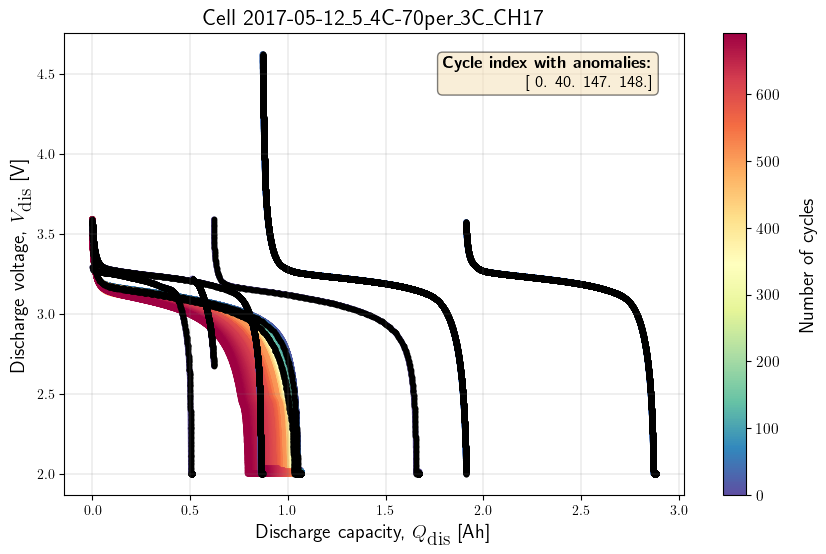

In [9]:
# Plot cell data with true anomalies
# If the true outlier cycle index is not known,
# cycling data will be plotted without labels
benchdb.plot_cycle_data(
    df_selected_cell_without_labels,
    true_outlier_cycle_index)

# Features transformation

## Load the training features dataset

In [11]:
# Define the filepath to ``train_features_severson.db``
# DuckDB instance.
db_features_filepath = (
    Path.cwd()
    .parent.parent
    .joinpath("database","train_features_severson.db"))

# Load only the training features dataset
df_features_per_cell = benchdb.load_features_db(
    db_features_filepath,
    dataset_type="train")
print(df_features_per_cell.head(10).to_markdown())
print("*"*100)

unique_cycle_count = (
    df_features_per_cell["cycle_index"].unique())

Features database is found in the given filepath.
Features database is loaded.
****************************************************************************************************
|    |   max_diff_dQ |   log_max_diff_dQ |   cycle_index |   max_diff_dV |   log_max_diff_dV | cell_index                    |
|---:|--------------:|------------------:|--------------:|--------------:|------------------:|:------------------------------|
|  0 |    0.00638794 |          -5.05334 |             0 |     1.56415   |          0.447343 | 2017-05-12_5_4C-70per_3C_CH17 |
|  1 |    0.00633758 |          -5.06126 |             1 |     0.0237265 |         -3.74116  | 2017-05-12_5_4C-70per_3C_CH17 |
|  2 |    0.00632072 |          -5.06392 |             2 |     0.0226841 |         -3.78609  | 2017-05-12_5_4C-70per_3C_CH17 |
|  3 |    0.00625887 |          -5.07376 |             3 |     0.0278988 |         -3.57917  | 2017-05-12_5_4C-70per_3C_CH17 |
|  4 |    0.00623644 |          -5.07735 |             4 |

## Calculate bubble size ratio

In [12]:
# Calculate the bubble size ratio for plotting
df_bubble_size_dQ = bstats.calculate_bubble_size_ratio(
    df_variable=df_features_per_cell["max_diff_dQ"])

df_bubble_size_dV = bstats.calculate_bubble_size_ratio(
    df_variable=df_features_per_cell["max_diff_dV"])

bubble_size = (
    np.abs(df_bubble_size_dV)
    * np.abs(df_bubble_size_dQ))

Feature mean: 0.00641125672398844
Feature max: 0.042899057000000074
Feature min: 0.006194469999999952
Feature std: 0.0019646872892444154
**********************************************************************
Feature mean: 0.04105323627167629
Feature max: 2.612268400000005
Feature min: 0.022684100000000207
Feature std: 0.11397361246602544
**********************************************************************


## Plot the bubble chart and label the true outliers

Potential anomalous cycle: 0.0
x-position of the text: -5.053343441284631
y-position of the text: 0.44734305691240445
----------------------------------------------------------------------
Potential anomalous cycle: 40.0
x-position of the text: -5.066424997988364
y-position of the text: 0.9602189626435208
----------------------------------------------------------------------
Potential anomalous cycle: 147.0
x-position of the text: -3.1508950320267735
y-position of the text: -3.5256965450993665
----------------------------------------------------------------------
Potential anomalous cycle: 148.0
x-position of the text: -3.1489054346417387
y-position of the text: -3.6794044837514233
----------------------------------------------------------------------


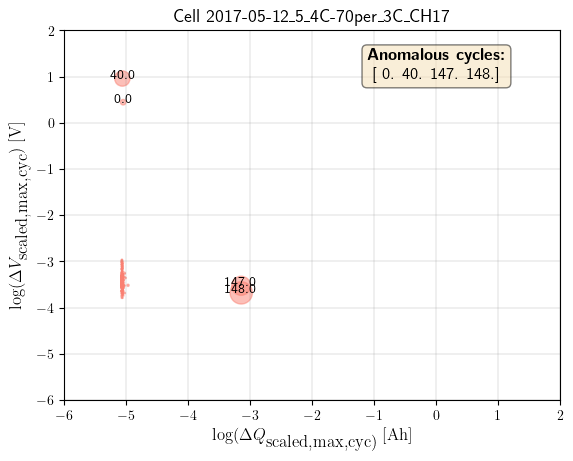

In [13]:
# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=df_features_per_cell["log_max_diff_dQ"],
    yseries=df_features_per_cell["log_max_diff_dV"],
    bubble_size=bubble_size,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=true_outlier_cycle_index)

axplot.set_title(
    f"Cell {selected_cell_label}", fontsize=13)

axplot.set_xlabel(
    r"$\log(\Delta Q_\textrm{scaled,max,cyc)}\;\textrm{[Ah]}$",
    fontsize=12)
axplot.set_ylabel(
    r"$\log(\Delta V_\textrm{scaled,max,cyc})\;\textrm{[V]}$",
    fontsize=12)

output_fig_filename = (
    "log_bubble_plot_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir.joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=200,
    bbox_inches="tight")

plt.show()

# Hyperparameter tuning

## Create optuna study

In [143]:
# 1) Instantiate an optuna study for iForest model

sampler = optuna.samplers.TPESampler(seed=42)

selected_feature_cols = (
    "cycle_index",
    "log_max_diff_dQ",
    "log_max_diff_dV")

if_study = optuna.create_study(
    study_name="iforest_hyperparam_regr",
    sampler=sampler,
    directions=["minimize","maximize"])


if_study.optimize(
    lambda trial: hp.objective(
        trial,
        model_id="iforest",
        df_feature_dataset=df_features_per_cell,
        selected_feature_cols=selected_feature_cols,
        selected_cell_label=selected_cell_label,
        #df_benchmark_dataset=df_selected_cell,
        ),
    n_trials=20)

[I 2025-09-25 01:38:18,374] A new study created in memory with name: iforest_hyperparam_regr
[I 2025-09-25 01:38:19,366] Trial 0 finished with values: [0.2005849659292784, 0.9913294797687862] and parameters: {'contamination': 0.18727005942368125, 'n_estimators': 500, 'max_samples': 400, 'threshold': 0.5986584841970366}.
[I 2025-09-25 01:38:19,685] Trial 1 finished with values: [0.8636856621637496, 0.9971098265895953] and parameters: {'contamination': 0.07800932022121826, 'n_estimators': 150, 'max_samples': 100, 'threshold': 0.8661761457749352}.
[I 2025-09-25 01:38:20,441] Trial 2 finished with values: [0.9316964138883296, 0.9985549132947977] and parameters: {'contamination': 0.3005575058716044, 'n_estimators': 400, 'max_samples': 100, 'threshold': 0.9699098521619943}.
[I 2025-09-25 01:38:20,712] Trial 3 finished with values: [0.1140953933885725, 0.6632947976878613] and parameters: {'contamination': 0.41622132040021087, 'n_estimators': 150, 'max_samples': 150, 'threshold': 0.18340450985

## Aggregate best trials

In [144]:
schema_iforest = {
    "threshold": "median",
    "contamination": "median",
    "n_estimators": "median_int",
    "max_samples": "median_int",
}

optimal_trials_list = hp.optimal_trails_detection(if_study)

df_iforest_hyperparam = hp.aggregate_best_trials(
    optimal_trials_list,
    cell_label=selected_cell_label,
    model_id="iforest",
    schema=schema_iforest)

df_iforest_hyperparam

,ml_model,cell_index,threshold,contamination,n_estimators,max_samples
0,iforest,2017-05-12_5_4C-70per_3C_CH17,0.747394,0.032526,400,500


## Plot pareto front

/home/basf/nasbattds/osbad/src/osbad/hyperparam.py:1085: ExperimentalWarning:

optuna.visualization.matplotlib._pareto_front.plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.



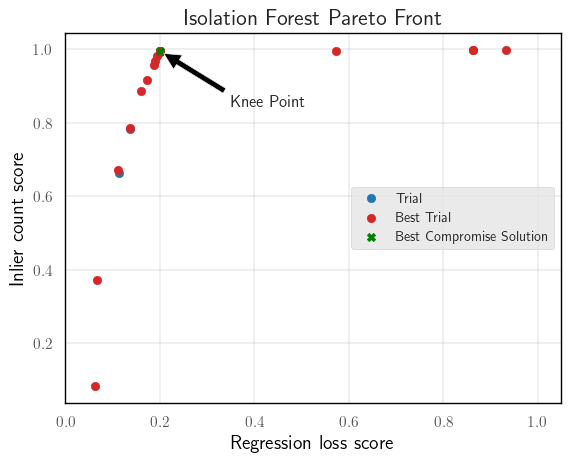

In [145]:
hp.plot_proxy_pareto_front(
    if_study,
    selected_cell_label,
    fig_title="Isolation Forest Pareto Front")

## Export current hyperparameters to CSV 

In [146]:
# Export current hyperparameters to CSV
hyperparam_filepath =  PIPELINE_OUTPUT_DIR.joinpath(
    "hyperparams_iforest.csv")

hp.export_current_hyperparam(
    df_iforest_hyperparam,
    selected_cell_label,
    export_csv_filepath=hyperparam_filepath)

Have the hyperparam for 2017-05-12_5_4C-70per_3C_CH17 been evaluated?
True
**********************************************************************
Hyperparameters for 2017-05-12_5_4C-70per_3C_CH17 already exists in the CSV file!


,ml_model,cell_index,threshold,contamination,n_estimators,max_samples
0,iforest,2017-05-12_5_4C-70per_3C_CH17,0.747394,0.032526,400,500


# Train model with best trial parameters

## Load best trial parameters from CSV output

In [147]:
# Test reading from exported metrics
df_hyperparam_from_csv = pd.read_csv(hyperparam_filepath)

df_param_per_cell = df_hyperparam_from_csv[
    df_hyperparam_from_csv["cell_index"] == selected_cell_label]
df_param_per_cell

,ml_model,cell_index,threshold,contamination,n_estimators,max_samples
0,iforest,2017-05-12_5_4C-70per_3C_CH17,0.747394,0.032526,400,500


## Create a dict for best trial parameters

In [134]:
param_dict = {
    "contamination": df_param_per_cell["contamination"].values[0],
    "n_estimators": df_param_per_cell["n_estimators"].values[0],
    "max_samples": df_param_per_cell["max_samples"].values[0],
    "threshold": df_param_per_cell["threshold"].values[0]
}

print(param_dict)

{'contamination': np.float64(0.03252579649263976), 'n_estimators': np.int64(400), 'max_samples': np.int64(500), 'threshold': np.float64(0.747394187305209)}


## Run the model with best trial parameters

In [135]:
cfg = hp.MODEL_CONFIG["iforest"]

selected_feature_cols = (
    "log_max_diff_dQ",
    "log_max_diff_dV")

runner = ModelRunner(
    cell_label=selected_cell_label,
    df_input_features=df_features_per_cell,
    selected_feature_cols=selected_feature_cols
)

Xdata = runner.create_model_x_input()

model = cfg.model_param(param_dict)
print(model)
model.fit(Xdata)
proba = model.predict_proba(Xdata)

pred_outlier_indices, pred_outlier_score = runner.pred_outlier_indices_from_proba(
    proba=proba,
    threshold=param_dict["threshold"],
    outlier_col=cfg.proba_col
)

pred_outlier_indices, pred_outlier_score

IForest(behaviour='new', bootstrap=False,
    contamination=np.float64(0.03252579649263976), max_features=1.0,
    max_samples=np.int64(500), n_estimators=np.int64(400), n_jobs=-1,
    random_state=42, verbose=0)


(array([  0,  40, 147, 148]),
 array([0.93495265, 0.97213625, 0.98874934, 1.        ]))

## Get df_outliers_pred

In [136]:
df_outliers_pred = df_features_per_cell[
    df_features_per_cell["cycle_index"].isin(pred_outlier_indices)].copy()

df_outliers_pred["outlier_prob"] = pred_outlier_score
df_outliers_pred

,max_diff_dQ,log_max_diff_dQ,cycle_index,max_diff_dV,log_max_diff_dV,cell_index,outlier_prob
0,0.006388,-5.053343,0.0,1.564151,0.447343,2017-05-12_5_4C-70per_3C_CH17,0.934953
40,0.006305,-5.066425,40.0,2.612268,0.960219,2017-05-12_5_4C-70per_3C_CH17,0.972136
147,0.042814,-3.150895,147.0,0.029431,-3.525697,2017-05-12_5_4C-70per_3C_CH17,0.988749
148,0.042899,-3.148905,148.0,0.025238,-3.679404,2017-05-12_5_4C-70per_3C_CH17,1.000000


## Predict anomaly score map

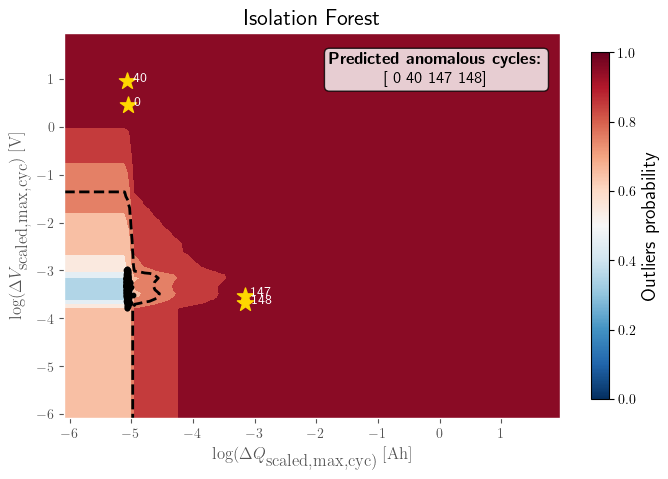

In [137]:
axplot = runner.predict_anomaly_score_map(
    selected_model=model,
    model_name="Isolation Forest",
    xoutliers=df_outliers_pred["log_max_diff_dQ"],
    youtliers=df_outliers_pred["log_max_diff_dV"],
    pred_outliers_index=pred_outlier_indices,
    threshold=param_dict["threshold"]
)

# Model performance evaluation

In [138]:
df_eval_outlier = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=pred_outlier_indices)

## Confusion matrix

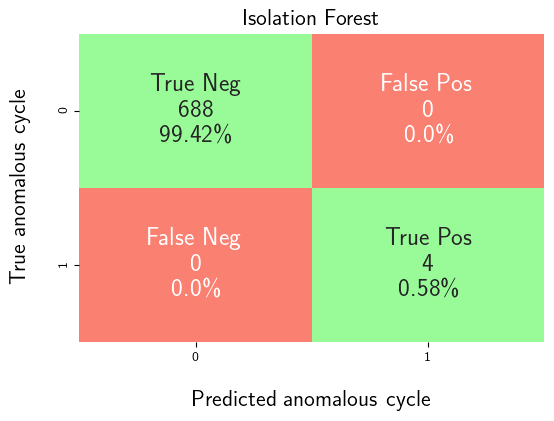

In [139]:
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier["true_outlier"],
    y_pred=df_eval_outlier["pred_outlier"])

axplot.set_title(
    "Isolation Forest",
    fontsize=16)

output_fig_filename = (
    "conf_matrix_iforest_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Evaluate model performance

In [140]:
df_current_eval_metrics = modval.eval_model_performance(
    model_name="iforest",
    selected_cell_label=selected_cell_label,
    df_eval_outliers=df_eval_outlier)

df_current_eval_metrics

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
MCC-score: 1.0
****************************************************************************************************


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,iforest,2017-05-12_5_4C-70per_3C_CH17,1.0,1.0,1.0,1.0,1.0


## Export model performance metrics to CSV output

In [141]:
# Export current metrics to CSV
hyperparam_eval_filepath =  Path.cwd().joinpath(
    "eval_metrics_hp_single_cell.csv")

hp.export_current_model_metrics(
    model_name="iforest",
    selected_cell_label=selected_cell_label,
    df_current_eval_metrics=df_current_eval_metrics,
    export_csv_filepath=hyperparam_eval_filepath)

Exporting evaluation metrics to CSV:


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,iforest,2017-05-12_5_4C-70per_3C_CH17,1.0,1.0,1.0,1.0,1.0
